In [63]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import f_regression, chi2, SelectKBest, RFE
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
plt.rcParams['figure.dpi'] = 200
plt.style.use('ggplot')
import optuna
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

In [64]:
plt.rcParams['figure.figsize'] = [25,18]

In [65]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
sample = pd.read_csv("../data/sample_submission.csv")
df_train.shape, df_test.shape, sample.shape

((1460, 81), (1459, 80), (1459, 2))

In [66]:
pd.set_option('display.max_columns', None)
pd.DataFrame(data={'NaN_count': df_train.isna().sum(), 'data_type':df_train.dtypes})

,NaN_count,data_type
Id,0,int64
MSSubClass,0,int64
MSZoning,0,object
LotFrontage,259,float64
LotArea,0,int64
...,...,...
MoSold,0,int64
YrSold,0,int64
SaleType,0,object
SaleCondition,0,object


In [67]:
num_features = df_train.select_dtypes(exclude='object')
cat_features = df_train.select_dtypes(include='object')
num_features.shape, cat_features.shape

((1460, 38), (1460, 43))

In [68]:
names = list(df_train.columns.values)
names

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [69]:
pd.DataFrame(data={'NaN_count': cat_features.isna().sum(), 'data_type':cat_features.dtypes})

,NaN_count,data_type
MSZoning,0,object
Street,0,object
Alley,1369,object
LotShape,0,object
LandContour,0,object
Utilities,0,object
LotConfig,0,object
LandSlope,0,object
Neighborhood,0,object
Condition1,0,object


In [70]:
#'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars' - перенести в num
# cat_features_droped = cat_features.drop(['Alley', 'SaleType', 'Electrical'], axis=1)

In [71]:
columns_with_nan = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 

In [72]:

my_imputer = ColumnTransformer(
    transformers = [
        ('num_imputer', SimpleImputer(strategy='constant', fill_value='zero'), columns_with_nan),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

In [73]:
cat_features_filled = my_imputer.fit_transform(cat_features)


In [74]:
pd.DataFrame(data={'NaN_count': cat_features_filled.isna().sum(), 'data_type':cat_features_filled.dtypes})
# sum(num_features_filled.isna().sum())

,NaN_count,data_type
Alley,0,object
MasVnrType,0,object
BsmtQual,0,object
BsmtCond,0,object
BsmtExposure,0,object
BsmtFinType1,0,object
BsmtFinType2,0,object
Electrical,0,object
FireplaceQu,0,object
GarageType,0,object


In [75]:
encoding_columns = ['Alley', 'SaleType', 'ExterQual', 'KitchenQual', 'Heating', 'BsmtQual', 'BsmtCond', 'SaleCondition', 'GarageQual',
                    'ExterCond', 'LotShape', 'MSZoning', 'GarageFinish', 'Street', 'Neighborhood', 'BsmtExposure',
                    'Foundation', 'CentralAir', 'FireplaceQu', 'LotConfig', 'Electrical', 'Condition2', 'LandContour',
                    'LandSlope', 'GarageType', 'MasVnrType', 'MiscFeature', 'PoolQC', 'HouseStyle', 'Exterior2nd',
                    'Fence', 'BsmtFinType1', 'PavedDrive', 'HeatingQC', 'Exterior1st', 'GarageCond', 'BldgType',
                    'BsmtFinType2', 'Utilities', 'RoofMatl', 'Functional', 'Condition1', 'RoofStyle'
                    ] 

my_encoder = ColumnTransformer(
    [
        ('ordinal_encoding', OrdinalEncoder(), encoding_columns),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [76]:
cat_features_encoded = my_encoder.fit_transform(cat_features_filled)


In [77]:
cat_features_encoded.describe()

,Alley,SaleType,ExterQual,KitchenQual,Heating,BsmtQual,BsmtCond,SaleCondition,GarageQual,ExterCond,LotShape,MSZoning,GarageFinish,Street,Neighborhood,BsmtExposure,Foundation,CentralAir,FireplaceQu,LotConfig,Electrical,Condition2,LandContour,LandSlope,GarageType,MasVnrType,MiscFeature,PoolQC,HouseStyle,Exterior2nd,Fence,BsmtFinType1,PavedDrive,HeatingQC,Exterior1st,GarageCond,BldgType,BsmtFinType2,Utilities,RoofMatl,Functional,Condition1,RoofStyle
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1.903425,7.513014,2.539726,2.339726,1.036301,2.305479,2.842466,3.770548,3.927397,3.733562,1.942466,3.028767,1.284247,0.995890,12.251370,2.310274,1.396575,0.934932,3.804795,3.019178,3.682877,2.008219,2.777397,0.062329,2.485616,2.271918,3.922603,2.991096,3.038356,10.339726,3.504795,2.815068,1.856164,1.538356,9.624658,3.960959,0.493151,4.741781,0.000685,1.075342,5.749315,2.031507,1.410274
std,0.394776,1.552100,0.693995,0.830161,0.295124,0.899225,0.676527,1.100854,0.647822,0.731807,1.409156,0.632017,0.892831,0.063996,6.013735,1.165663,0.722394,0.246731,1.398954,1.622634,1.051834,0.259040,0.707666,0.276232,1.933206,0.932635,0.404103,0.140703,1.911305,3.540570,1.082912,1.874410,0.496592,1.739524,3.197659,0.566832,1.198277,0.946713,0.026171,0.599127,0.979659,0.868515,0.834998
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,2.000000,2.000000,1.000000,2.000000,3.000000,4.000000,4.000000,4.000000,0.000000,3.000000,1.000000,1.000000,7.000000,2.000000,1.000000,1.000000,2.000000,2.000000,4.000000,2.000000,3.000000,0.000000,1.000000,1.000000,4.000000,3.000000,2.000000,8.000000,4.000000,1.000000,2.000000,0.000000,8.000000,4.000000,0.000000,5.000000,0.000000,1.000000,6.000000,2.000000,1.000000
50%,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,1.000000,1.000000,12.000000,3.000000,1.000000,1.000000,4.000000,4.000000,4.000000,2.000000,3.000000,0.000000,1.000000,3.000000,4.000000,3.000000,2.000000,13.000000,4.000000,2.000000,2.000000,0.000000,12.000000,4.000000,0.000000,5.000000,0.000000,1.000000,6.000000,2.000000,1.000000
75%,2.000000,8.000000,3.000000,3.000000,1.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,2.000000,1.000000,17.000000,3.000000,2.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,0.000000,5.000000,3.000000,4.000000,3.000000,5.000000,13.000000,4.000000,5.000000,2.000000,4.000000,12.000000,4.000000,0.000000,5.000000,0.000000,1.000000,6.000000,2.000000,1.000000
max,2.000000,8.000000,3.000000,3.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,3.000000,4.000000,3.000000,1.000000,24.000000,4.000000,5.000000,1.000000,5.000000,4.000000,5.000000,7.000000,3.000000,2.000000,6.000000,3.000000,4.000000,3.000000,7.000000,15.000000,4.000000,6.000000,2.000000,4.000000,14.000000,5.000000,4.000000,6.000000,1.000000,7.000000,6.000000,8.000000,5.000000


In [78]:
# cat_features_encoded[cat_features_encoded['Exterior2nd'] == 'AsphShn']

In [79]:
cat_features_encoded['SalePrice'] = num_features['SalePrice']

In [80]:
X_c, y_c = cat_features_encoded.drop('SalePrice', axis=1), cat_features_encoded['SalePrice']


In [81]:
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X_c, y_c, test_size=0.2)


In [82]:
df_train.describe(exclude='object')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [83]:
df_train.describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [84]:
df_train['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

### Матрица корреляции

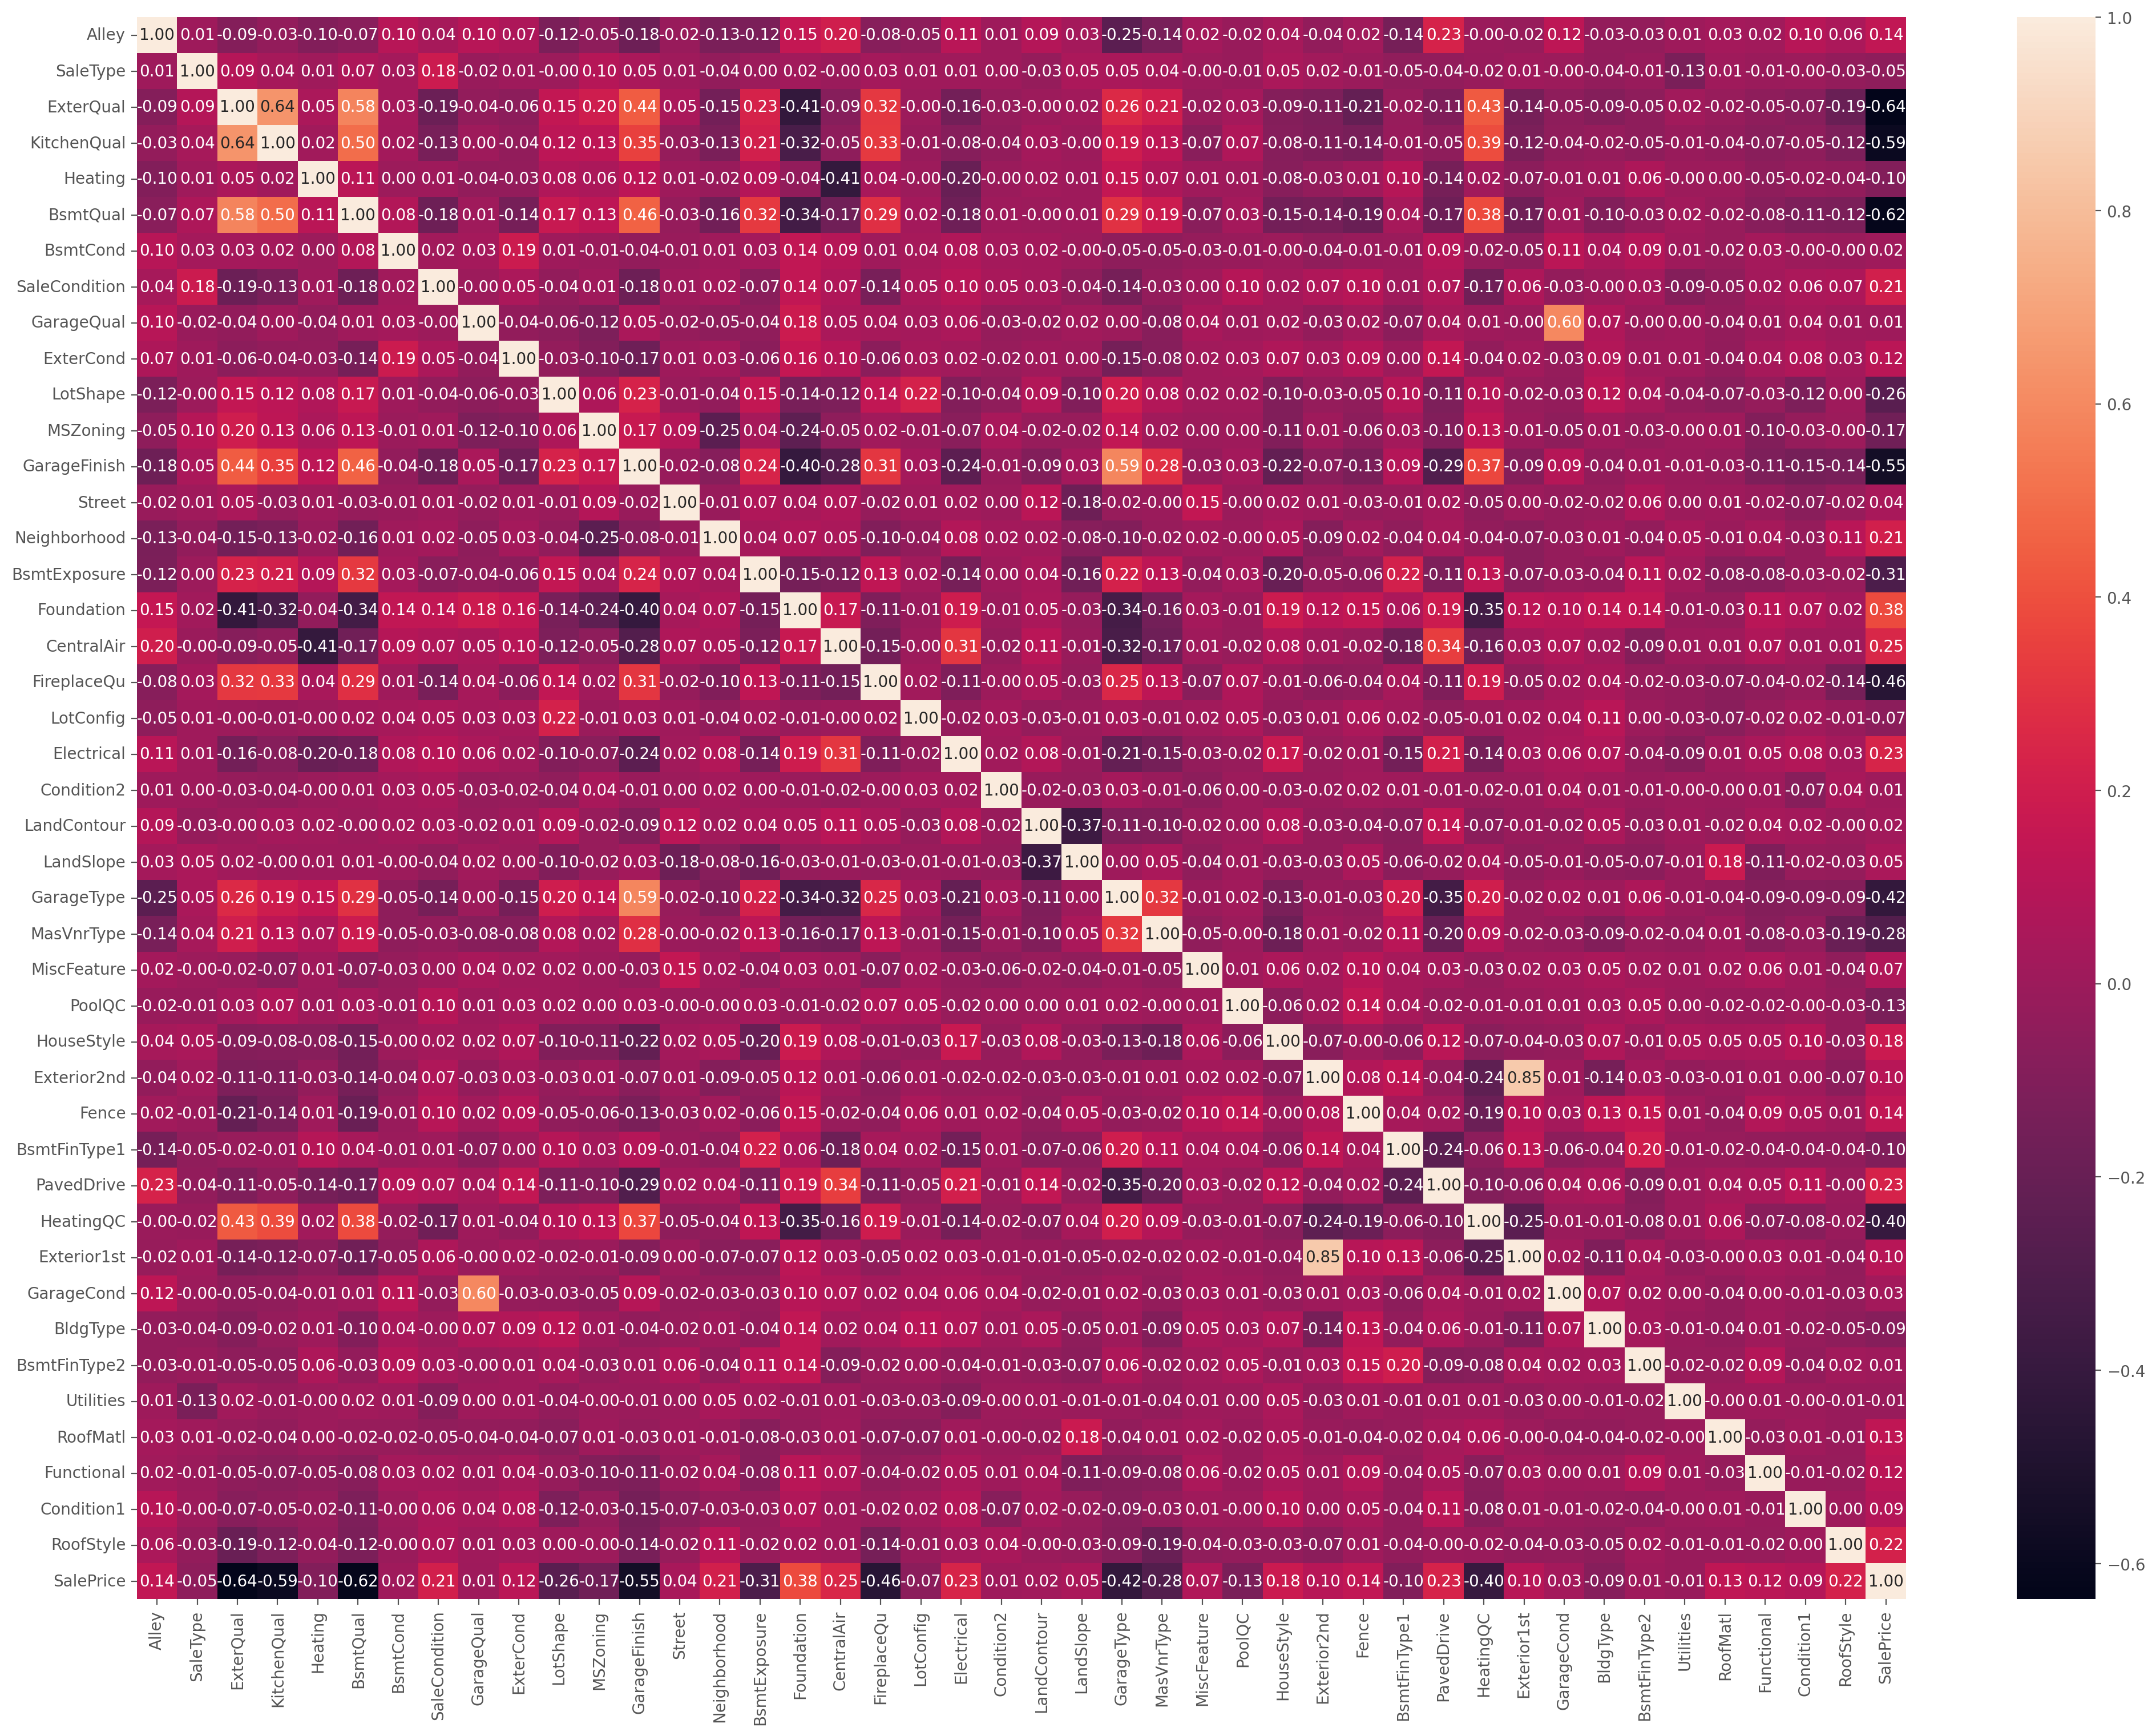

In [85]:
sns.heatmap(cat_features_encoded.corr(), annot=True, fmt='.2f');

In [86]:
cat_features_encoded.corr()['SalePrice'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

ExterQual       -0.636884
BsmtQual        -0.620886
KitchenQual     -0.589189
GarageFinish    -0.549247
FireplaceQu     -0.459605
GarageType      -0.415283
HeatingQC       -0.400178
Foundation       0.382479
BsmtExposure    -0.309043
MasVnrType      -0.281554
LotShape        -0.255580
CentralAir       0.251328
Electrical       0.234716
PavedDrive       0.231357
RoofStyle        0.222405
SaleCondition    0.213092
Neighborhood     0.210851
HouseStyle       0.180163
MSZoning        -0.166872
Fence            0.140640
Alley            0.139868
RoofMatl         0.132383
PoolQC          -0.126070
ExterCond        0.117303
Functional       0.115328
Exterior2nd      0.103766
Exterior1st      0.103551
BsmtFinType1    -0.103114
Heating         -0.098812
Condition1       0.091155
BldgType        -0.085591
MiscFeature      0.073609
LotConfig       -0.067396
SaleType        -0.054911
LandSlope        0.051152
Street           0.041036
GarageCond       0.025149
LandContour      0.015453
BsmtCond    

### F-test

In [87]:
pd.Series(dict(zip(X_c.columns, f_regression(X_c, y_c)[1]))).sort_values(ascending=False)

GarageQual        7.933651e-01
Condition2        7.742507e-01
BsmtFinType2      7.588526e-01
Utilities         5.847168e-01
BsmtCond          5.653553e-01
LandContour       5.551926e-01
GarageCond        3.369142e-01
Street            1.170486e-01
LandSlope         5.068585e-02
SaleType          3.590952e-02
LotConfig         9.997322e-03
MiscFeature       4.892952e-03
BldgType          1.061793e-03
Condition1        4.879177e-04
Heating           1.558060e-04
BsmtFinType1      7.909700e-05
Exterior1st       7.371973e-05
Exterior2nd       7.120994e-05
Functional        9.978135e-06
ExterCond         6.995963e-06
PoolQC            1.349758e-06
RoofMatl          3.847008e-07
Alley             8.043098e-08
Fence             6.810587e-08
MSZoning          1.401300e-10
HouseStyle        4.064283e-12
Neighborhood      3.906733e-16
SaleCondition     1.872729e-16
RoofStyle         8.060304e-18
PavedDrive        3.418340e-19
Electrical        1.008341e-19
CentralAir        1.809506e-22
LotShape

### Lasso

In [88]:
lasso = Lasso(alpha=100)
lasso.fit(X_c, y_c)

Lasso(alpha=100)

In [89]:
pd.Series(dict(zip(X_c.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=True)

Alley                0.000000
Utilities           -0.000000
MSZoning           158.495678
BsmtFinType2      -233.550235
Condition1        -330.656304
LotConfig         -860.193854
Neighborhood      1003.588047
LandContour       1055.363923
SaleType         -1092.254153
Fence             1182.608747
ExterCond         1191.879563
Condition2       -1192.548217
BsmtFinType1     -1356.498324
Exterior2nd       1462.259559
HouseStyle        1519.840923
GarageQual       -1592.526894
GarageType       -1645.468222
BsmtCond          1895.636159
Exterior1st      -1953.129631
HeatingQC        -1995.715021
LotShape         -2428.520499
Functional        2525.720902
Electrical        2619.801466
BsmtExposure     -2771.568663
Heating           3052.948923
SaleCondition     3692.507657
PavedDrive        3880.829355
MiscFeature       4365.266630
GarageCond        4390.235900
Foundation        4804.275105
MasVnrType       -5773.805280
RoofStyle         6458.222951
FireplaceQu      -8214.539665
GarageFini

### Feature_importances деревянных моделей

In [90]:
rf = RandomForestRegressor()

rf.fit(X_c, y_c)

RandomForestRegressor()

In [91]:
pd.Series(dict(zip(X_c.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=True)

Utilities        0.000007
Street           0.000066
Condition2       0.000383
MiscFeature      0.000672
Electrical       0.001182
GarageCond       0.001202
Alley            0.001357
Functional       0.001383
PavedDrive       0.001550
Heating          0.002077
BsmtCond         0.003143
CentralAir       0.003894
GarageQual       0.004176
Condition1       0.004779
SaleType         0.005730
Foundation       0.005882
BsmtFinType2     0.006359
Fence            0.007502
LandContour      0.007621
LandSlope        0.007707
HeatingQC        0.007776
LotShape         0.008849
MasVnrType       0.008965
PoolQC           0.009527
LotConfig        0.009862
SaleCondition    0.010132
MSZoning         0.010214
RoofStyle        0.010548
BldgType         0.011144
ExterCond        0.011249
BsmtFinType1     0.013343
Exterior1st      0.013403
RoofMatl         0.013640
Exterior2nd      0.014828
HouseStyle       0.015244
GarageFinish     0.016792
BsmtExposure     0.021382
GarageType       0.042148
Neighborhood

In [92]:
X_c['random'] = np.random.uniform(0,100, size=X_c.shape[0])

In [93]:
rf = RandomForestRegressor()
rf.fit(X_c, y_c)
pd.Series(dict(zip(X_c.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=True)

Utilities        0.000009
Street           0.000121
Condition2       0.000351
MiscFeature      0.000546
Electrical       0.000974
GarageCond       0.001009
Alley            0.001229
Functional       0.001410
PavedDrive       0.001625
Heating          0.002023
BsmtCond         0.002095
GarageQual       0.003903
CentralAir       0.004323
Condition1       0.004362
BsmtFinType2     0.004816
Foundation       0.005546
Fence            0.006542
SaleType         0.006740
LandContour      0.006743
HeatingQC        0.007168
LotConfig        0.007229
ExterCond        0.007327
LandSlope        0.007536
LotShape         0.007579
RoofStyle        0.007905
MasVnrType       0.008319
PoolQC           0.009047
SaleCondition    0.009324
MSZoning         0.010174
BldgType         0.011123
Exterior1st      0.013316
HouseStyle       0.013374
BsmtFinType1     0.013580
RoofMatl         0.014047
GarageFinish     0.014124
Exterior2nd      0.014418
BsmtExposure     0.018079
random           0.038755
GarageType  

In [94]:
X_c.drop('random', axis=1, inplace=True)

### Permutation importance

In [95]:
rf = RandomForestRegressor()
rf.fit(X_valid_c, y_valid_c)

RandomForestRegressor()

In [96]:
r = permutation_importance(rf, X_valid_c, y_valid_c, n_repeats=30, random_state=0)

In [97]:
pd.Series(dict(zip(X_c.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=True)

Utilities        0.000000
PoolQC          -0.000002
Condition2      -0.000016
Street           0.000025
Heating          0.000053
MiscFeature      0.000175
Alley            0.000335
GarageCond       0.000424
Electrical       0.000486
Functional       0.000893
LandContour      0.001139
LandSlope        0.001231
BsmtFinType2     0.001311
Fence            0.001317
PavedDrive       0.001534
BsmtCond         0.001757
GarageQual       0.001970
SaleType         0.002297
ExterCond        0.002586
Condition1       0.002598
LotShape         0.003558
LotConfig        0.003679
CentralAir       0.004316
Exterior2nd      0.004790
BldgType         0.004845
Exterior1st      0.005426
SaleCondition    0.006985
HeatingQC        0.007077
Foundation       0.007190
MSZoning         0.008974
RoofStyle        0.010696
BsmtFinType1     0.010993
HouseStyle       0.014647
MasVnrType       0.018164
BsmtExposure     0.026454
GarageFinish     0.032651
RoofMatl         0.035480
GarageType       0.047820
Neighborhood

In [98]:
X_c['random'] = np.random.uniform(0,100, size=X_c.shape[0])
X_train_new, X_valid_new, y_train_new, y_valid_new = train_test_split(X_c, y_c, test_size=0.2)

In [99]:
rf = RandomForestRegressor()
rf.fit(X_valid_new, y_valid_new)
r = permutation_importance(rf, X_valid_new, y_valid_new, n_repeats=30, random_state=0)
pd.Series(dict(zip(X_c.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=True)

Utilities        0.000000
MiscFeature      0.000115
RoofMatl         0.000165
Street           0.000168
Condition2       0.000232
Heating          0.000508
Electrical       0.000574
GarageCond       0.000620
Functional       0.000627
Alley            0.000884
BsmtFinType2     0.001018
BsmtCond         0.001067
PavedDrive       0.001188
ExterCond        0.001254
GarageQual       0.001722
Condition1       0.001738
CentralAir       0.003281
SaleType         0.003879
RoofStyle        0.004800
BldgType         0.004909
LotConfig        0.005137
LandContour      0.005783
Foundation       0.006037
Exterior2nd      0.007033
HeatingQC        0.007384
LotShape         0.007624
MasVnrType       0.009512
SaleCondition    0.010364
BsmtFinType1     0.011179
BsmtExposure     0.011402
Fence            0.015106
MSZoning         0.015890
random           0.019213
HouseStyle       0.021360
Neighborhood     0.027858
LandSlope        0.029528
GarageFinish     0.031362
GarageType       0.035014
Exterior1st 

In [100]:
X_c.drop('random', axis=1, inplace=True)

### Shap values

In [101]:
from catboost import CatBoostRegressor
shap.initjs()

In [102]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_c, y_c, verbose=False, plot=False)

In [103]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_c)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_c.iloc[0,:])

In [104]:
y_c.mean()

180921.19589041095

In [105]:
plt.rcParams['figure.dpi'] = 50
plt.rcParams['figure.figsize'] = [5,5]

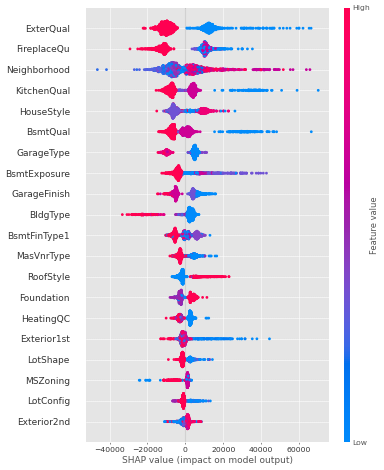

In [106]:
shap.summary_plot(shap_values, X_c)

### Chi2

In [107]:
select = SelectKBest(chi2, k=27)
X_new = select.fit_transform(X_train_c, y_train_c)


In [108]:
names = list(X_train_c.columns.values)
names.sort()
names[20:]

['GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'Neighborhood',
 'PavedDrive',
 'PoolQC',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities']

In [109]:
names = list(X_new.columns.values)
names.sort()
names

['BldgType',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtQual',
 'Condition1',
 'Electrical',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Foundation',
 'GarageFinish',
 'GarageType',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MasVnrType',
 'Neighborhood',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Utilities']

### RFE (Recursive Feature Elimination)

In [110]:
names = list(X_train_c.columns.values)
for i in range(0, 20):
    print(i, names[i])


0 Alley
1 SaleType
2 ExterQual
3 KitchenQual
4 Heating
5 BsmtQual
6 BsmtCond
7 SaleCondition
8 GarageQual
9 ExterCond
10 LotShape
11 MSZoning
12 GarageFinish
13 Street
14 Neighborhood
15 BsmtExposure
16 Foundation
17 CentralAir
18 FireplaceQu
19 LotConfig


In [111]:
for i in range(20, len(names)):
    print(i, names[i])


20 Electrical
21 Condition2
22 LandContour
23 LandSlope
24 GarageType
25 MasVnrType
26 MiscFeature
27 PoolQC
28 HouseStyle
29 Exterior2nd
30 Fence
31 BsmtFinType1
32 PavedDrive
33 HeatingQC
34 Exterior1st
35 GarageCond
36 BldgType
37 BsmtFinType2
38 Utilities
39 RoofMatl
40 Functional
41 Condition1
42 RoofStyle


In [112]:

lr = LinearRegression()
#select 5 the most informative features
rfe = RFE(estimator=lr, n_features_to_select=27) 
rfe.fit(X_train_c, y_train_c)
# y_pred = rfe.predict(X_train_n)
# print("Маска выбранных признаков:", rfe.support_)
# print("Ранги признаков:", rfe.ranking_)
selected_features = [f"feature_{i}" for i in range(X_train_c.shape[1]) if rfe.support_[i]]
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['feature_0', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_10', 'feature_12', 'feature_13', 'feature_16', 'feature_17', 'feature_18', 'feature_20', 'feature_21', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_32', 'feature_35', 'feature_36', 'feature_38', 'feature_39', 'feature_40', 'feature_42']


### Chi-2

In [113]:
# сделаем тест хи-квадрат для оценки независимости между признаком и таргетом. Низкое p - есть связь
p_values = []
for cat in cat_features_filled.columns:
    cont_table = pd.crosstab(X_train_c[cat], y_train_c)
    if (cont_table.values < 5).any():
        chi2, p, dof, ex = chi2_contingency(cont_table, correction=True)
    else:
        chi2, p, dof, ex = chi2_contingency(cont_table)
    p_values.append(p)
results = pd.DataFrame({'feature':cat_features_filled.columns, 'p_value':p_values})
results = results.sort_values(by='p_value')
results
# results.to_csv(r"cat_features_p_value.csv", index=False, sep=";")

,feature,p_value
38,KitchenQual,1.732694e-20
32,ExterQual,8.413777e-20
2,BsmtQual,1.458521e-18
42,SaleCondition,2.935502e-16
34,Foundation,7.441130e-16
18,LotShape,1.358854e-12
3,BsmtCond,1.282096e-10
33,ExterCond,8.384345e-10
4,BsmtExposure,2.262625e-08
16,MSZoning,6.482458e-08
